# Import Libraries & Dependencies

In [1]:
#import libraries and dependencies
from sklearn import tree
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestClassifier
from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import confusion_matrix,classification_report,plot_confusion_matrix,accuracy_score
from sklearn.model_selection import cross_val_score
from sklearn.model_selection import RepeatedKFold
from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import r2_score
from numpy import mean
from numpy import std
import numpy as np
import pandas as pd
import os
from dotenv import load_dotenv
from sqlalchemy import create_engine
import matplotlib.pyplot as plt
import seaborn as sns

In [2]:
#Create connection to postgres database EmployeeSQL
load_dotenv()
my_env_var = os.getenv('DB_CONNECTION_STRING')
engine = create_engine(my_env_var)
connection = engine.connect()
connection

In [3]:
real_estateFinal_df = pd.read_sql('SELECT * FROM "real_estate_final"', connection)
pd.set_option('display.max_columns', None)
real_estateFinal_df.sample(5)

,index,address,neighborhood,borough,bed,bath,days_on_market,compass_property_type,mls_property_subtype,mls_property_type,listed_price,sold_price,sold_date,zipcode,lat,long,year_built,dom_ranges,dom_tier,dom_lowerbound,dom_iqr,dom_upperbound,dom_extended,dom_outlier,walkable_false,walkable_true,health_level_dead,health_level_fair,health_level_good,health_level_poor,ada_access_no,ada_access_yes,ada_access_partial,type_is_active_cleanup_mild_threat,type_is_active_significant_threat,type_is_completed_clean,type_is_maintain_continued_threat,type_is_potential_threat,type_is_felony,type_is_violation,type_is_misdemeanor,danger_level_is_high,danger_level_is_low,lunch_eligibity_high_false_elem,lunch_eligibity_high_true_elem,type_is_top_25th_percentile_elem,type_is_50th_percentile_elem,type_is_75th_percentile_elem,type_is_bottom_25th_percentile_elem,lunch_eligibity_high_false_middle,lunch_eligibity_high_true_middle,type_is_top_25th_percentile_middle,type_is_50th_percentile_middle,type_is_75th_percentile_middle,type_is_bottom_25th_percentile_middle,lunch_eligibity_high_false_high,lunch_eligibity_high_true_high,type_is_top_25th_percentile_high,type_is_50th_percentile_high,type_is_75th_percentile_high,type_is_bottom_25th_percentile_high
5139,5138,33 forest ln,tottenville,staten island,3,1.5,94,house,single family - semi-attached,house,464900,429900,2020-12-28,10307,40.5071,-74.2443,1998-01-01,55-105,1,0,1,0,0,0,0,192,149,578,4548,176,2,2,0,0,0,2,0,0,7,9,10,1,25,2,0,2,0,0,0,1,0,0,1,0,0,0,0,0,0,0,0
24817,24817,"150-19 89th st, unit 3",lindenwood,queens,1,1.0,30,co-op,co-op,co-op,199990,193000,2020-03-23,11414,40.6617,-73.8478,None,<55,0,1,0,0,0,0,0,392,269,709,3487,185,1,1,0,0,0,1,0,0,62,21,69,17,135,3,0,1,2,0,0,3,0,0,3,0,0,0,0,0,0,0,0
33126,33126,"1170 ocean pkwy, unit 6b",midwood,brooklyn,1,1.0,217,co-op,0,co-op,329000,282000,2020-03-20,11230,40.6191,-73.9654,1965-01-01,188-388,3,0,0,0,1,0,0,294,237,1258,5452,389,1,0,1,0,0,1,0,0,95,92,195,37,345,1,3,0,3,1,0,1,1,0,1,1,0,1,0,0,0,1,0
28907,28907,851 52nd st,sunset park,brooklyn,1,1.0,105,townhouse,two family/all multi family,townhouse,0,860000,2020-11-03,11220,40.6385,-74.0153,2020-01-01,55-105,1,0,1,0,0,0,5,193,227,535,3744,171,4,0,1,4,0,10,0,0,237,105,339,109,572,0,6,1,1,3,1,0,1,0,1,0,0,0,1,0,0,1,0
3625,3622,"60-30 little neck pkwy, unit 3847",little neck,queens,0,1.0,105,co-op,0,co-op,0,195000,2020-02-21,11362,40.7613,-73.7331,None,55-105,1,0,1,0,0,0,416,0,166,462,3693,108,0,0,0,0,0,0,0,0,9,21,13,1,42,1,0,1,0,0,0,1,0,0,1,0,0,0,0,0,0,0,0


## Random Forest Classifier Model

This model will classify the property type based on all the features selected in the X value.

In [4]:
#assign X values from the Real Estate Final table for the model - cast all as int 
X = real_estateFinal_df[['zipcode', 'sold_price','bed', 'bath', 'days_on_market', 'dom_tier', 'dom_lowerbound', 'dom_iqr', 'dom_upperbound','dom_extended', 
            'dom_outlier', 'walkable_false', 'walkable_true', 'health_level_dead', 'health_level_fair', 'health_level_good',
            'health_level_poor', 'ada_access_no', 'ada_access_yes', 'ada_access_partial', 
            'type_is_active_cleanup_mild_threat','type_is_active_significant_threat','type_is_completed_clean',
            'type_is_maintain_continued_threat', 'type_is_potential_threat', 'type_is_felony', 'type_is_violation', 
            'type_is_misdemeanor', 'danger_level_is_high', 'danger_level_is_low', 'lunch_eligibity_high_false_elem',
            'lunch_eligibity_high_true_elem', 'type_is_top_25th_percentile_elem', 'type_is_50th_percentile_elem',
            'type_is_75th_percentile_elem', 'type_is_bottom_25th_percentile_elem', 'lunch_eligibity_high_false_middle',
            'lunch_eligibity_high_true_middle', 'type_is_top_25th_percentile_middle', 'type_is_50th_percentile_middle',
            'type_is_75th_percentile_middle', 'type_is_bottom_25th_percentile_middle', 'lunch_eligibity_high_false_high',
            'lunch_eligibity_high_true_high', 'type_is_top_25th_percentile_high', 'type_is_50th_percentile_high',
            'type_is_75th_percentile_high', 'type_is_bottom_25th_percentile_high']]

X.astype(int)

,zipcode,sold_price,bed,bath,days_on_market,dom_tier,dom_lowerbound,dom_iqr,dom_upperbound,dom_extended,dom_outlier,walkable_false,walkable_true,health_level_dead,health_level_fair,health_level_good,health_level_poor,ada_access_no,ada_access_yes,ada_access_partial,type_is_active_cleanup_mild_threat,type_is_active_significant_threat,type_is_completed_clean,type_is_maintain_continued_threat,type_is_potential_threat,type_is_felony,type_is_violation,type_is_misdemeanor,danger_level_is_high,danger_level_is_low,lunch_eligibity_high_false_elem,lunch_eligibity_high_true_elem,type_is_top_25th_percentile_elem,type_is_50th_percentile_elem,type_is_75th_percentile_elem,type_is_bottom_25th_percentile_elem,lunch_eligibity_high_false_middle,lunch_eligibity_high_true_middle,type_is_top_25th_percentile_middle,type_is_50th_percentile_middle,type_is_75th_percentile_middle,type_is_bottom_25th_percentile_middle,lunch_eligibity_high_false_high,lunch_eligibity_high_true_high,type_is_top_25th_percentile_high,type_is_50th_percentile_high,type_is_75th_percentile_high,type_is_bottom_25th_percentile_high
0,10011,1646000,1,2,75,1,0,1,0,0,0,0,85,94,195,1769,76,5,2,0,1,0,10,0,1,664,200,924,252,1536,4,0,4,0,0,0,3,0,1,1,1,0,3,4,1,1,1,4
1,10023,799000,1,1,60,1,0,1,0,0,0,0,104,57,375,1756,72,2,2,0,0,0,3,0,0,339,158,971,151,1317,4,0,3,0,1,0,3,0,1,1,0,1,3,3,2,1,0,3
2,10025,670000,1,1,122,2,0,0,1,0,0,0,64,126,576,2796,198,4,1,0,1,0,0,0,0,401,177,891,169,1300,5,1,3,2,0,1,4,3,0,4,2,1,0,0,0,0,0,0
3,10011,2175000,2,3,72,1,0,1,0,0,0,0,85,94,195,1769,76,5,2,0,1,0,10,0,1,664,200,924,252,1536,4,0,4,0,0,0,3,0,1,1,1,0,3,4,1,1,1,4
4,10024,2333000,2,2,134,2,0,0,1,0,0,0,67,80,370,2763,98,3,0,0,0,0,2,0,0,130,78,191,42,357,5,0,5,0,0,0,4,1,3,2,0,0,1,1,0,0,1,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
37223,11235,230000,1,1,105,1,0,1,0,0,0,1,467,394,1276,3228,259,11,1,0,3,0,3,0,0,42,28,60,7,123,2,4,3,2,1,0,1,3,1,2,1,0,2,5,1,0,0,6
37224,11235,2050000,7,5,105,1,0,1,0,0,0,1,467,394,1276,3228,259,11,1,0,3,0,3,0,0,42,28,60,7,123,2,4,3,2,1,0,1,3,1,2,1,0,2,5,1,0,0,6
37225,11235,800000,8,1,105,1,0,1,0,0,0,1,467,394,1276,3228,259,11,1,0,3,0,3,0,0,42,28,60,7,123,2,4,3,2,1,0,1,3,1,2,1,0,2,5,1,0,0,6
37226,11235,940000,8,4,105,1,0,1,0,0,0,1,467,394,1276,3228,259,11,1,0,3,0,3,0,0,42,28,60,7,123,2,4,3,2,1,0,1,3,1,2,1,0,2,5,1,0,0,6


In [5]:
#assign X values from the Real Estate Final table for the model - cast all as int 
y = real_estateFinal_df[['compass_property_type']]
y.dtypes

compass_property_type    object
dtype: object

In [6]:
X_train, X_test, y_train, y_test = train_test_split(X, y, random_state=42)

In [7]:
rf = RandomForestClassifier(n_estimators=100, random_state=42, max_features="log2", min_samples_split=3, min_samples_leaf=2)
rf = rf.fit(X_train, y_train)
rf.score(X_test, y_test)

<ipython-input-7-4edcdd1097bd>:2: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  rf = rf.fit(X_train, y_train)


0.8755775222950467

In [8]:
sorted(zip(rf.feature_importances_, X.columns), reverse=True)

[(0.22937887005945629, 'sold_price'),
 (0.17157503049424774, 'bed'),
 (0.08995516554045549, 'bath'),
 (0.055287598042701926, 'days_on_market'),
 (0.032951357087595105, 'zipcode'),
 (0.026912989427728955, 'health_level_dead'),
 (0.023816581304704453, 'health_level_good'),
 (0.023638720858806653, 'walkable_true'),
 (0.022342969911560862, 'type_is_completed_clean'),
 (0.020196481164870786, 'type_is_misdemeanor'),
 (0.019642908882815273, 'health_level_poor'),
 (0.019560461387406344, 'type_is_active_cleanup_mild_threat'),
 (0.016773650327539826, 'health_level_fair'),
 (0.015653110835225057, 'danger_level_is_low'),
 (0.014505345782316647, 'type_is_violation'),
 (0.013669022328834459, 'type_is_felony'),
 (0.01334061365757357, 'danger_level_is_high'),
 (0.01240146526081054, 'dom_iqr'),
 (0.012025821766744577, 'dom_tier'),
 (0.011765389358064168, 'type_is_bottom_25th_percentile_elem'),
 (0.011210517793339885, 'lunch_eligibity_high_true_elem'),
 (0.010410432394504043, 'type_is_top_25th_percentil

In [9]:
y_pred = rf.predict(X_test)

In [10]:
confusion_matrix(y_test, y_pred)

array([[1820,  188,    3,   73],
       [ 203, 1416,    2,  228],
       [  15,   12,   48,  207],
       [  79,  142,    6, 4865]], dtype=int64)

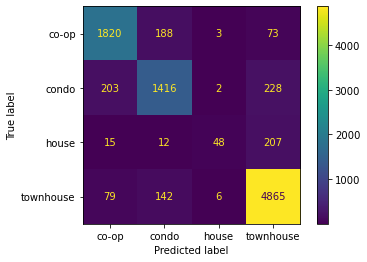

In [11]:
plot_confusion_matrix(rf,X_test,y_test)

In [13]:
print(classification_report(y_test,y_pred))

              precision    recall  f1-score   support

       co-op       0.86      0.87      0.87      2084
       condo       0.81      0.77      0.79      1849
       house       0.81      0.17      0.28       282
   townhouse       0.91      0.96      0.93      5092

    accuracy                           0.88      9307
   macro avg       0.85      0.69      0.72      9307
weighted avg       0.87      0.88      0.87      9307



## Random Forest Regression

In [42]:
X1 = real_estateFinal_df[['zipcode','bed', 'bath', 'days_on_market', 'dom_tier', 'dom_lowerbound', 'dom_iqr', 'dom_upperbound','dom_extended', 
            'dom_outlier', 'walkable_false', 'walkable_true', 'health_level_dead', 'health_level_fair', 'health_level_good',
            'health_level_poor', 'ada_access_no', 'ada_access_yes', 'ada_access_partial', 
            'type_is_active_cleanup_mild_threat','type_is_active_significant_threat','type_is_completed_clean',
            'type_is_maintain_continued_threat', 'type_is_potential_threat', 'type_is_felony', 'type_is_violation', 
            'type_is_misdemeanor', 'danger_level_is_high', 'danger_level_is_low', 'lunch_eligibity_high_false_elem',
            'lunch_eligibity_high_true_elem', 'type_is_top_25th_percentile_elem', 'type_is_50th_percentile_elem',
            'type_is_75th_percentile_elem', 'type_is_bottom_25th_percentile_elem', 'lunch_eligibity_high_false_middle',
            'lunch_eligibity_high_true_middle', 'type_is_top_25th_percentile_middle', 'type_is_50th_percentile_middle',
            'type_is_75th_percentile_middle', 'type_is_bottom_25th_percentile_middle', 'lunch_eligibity_high_false_high',
            'lunch_eligibity_high_true_high', 'type_is_top_25th_percentile_high', 'type_is_50th_percentile_high',
            'type_is_75th_percentile_high', 'type_is_bottom_25th_percentile_high']]

X1.astype(int)

y1 = real_estateFinal_df[['sold_price']]

In [43]:
X1.sample()

,zipcode,bed,bath,days_on_market,dom_tier,dom_lowerbound,dom_iqr,dom_upperbound,dom_extended,dom_outlier,walkable_false,walkable_true,health_level_dead,health_level_fair,health_level_good,health_level_poor,ada_access_no,ada_access_yes,ada_access_partial,type_is_active_cleanup_mild_threat,type_is_active_significant_threat,type_is_completed_clean,type_is_maintain_continued_threat,type_is_potential_threat,type_is_felony,type_is_violation,type_is_misdemeanor,danger_level_is_high,danger_level_is_low,lunch_eligibity_high_false_elem,lunch_eligibity_high_true_elem,type_is_top_25th_percentile_elem,type_is_50th_percentile_elem,type_is_75th_percentile_elem,type_is_bottom_25th_percentile_elem,lunch_eligibity_high_false_middle,lunch_eligibity_high_true_middle,type_is_top_25th_percentile_middle,type_is_50th_percentile_middle,type_is_75th_percentile_middle,type_is_bottom_25th_percentile_middle,lunch_eligibity_high_false_high,lunch_eligibity_high_true_high,type_is_top_25th_percentile_high,type_is_50th_percentile_high,type_is_75th_percentile_high,type_is_bottom_25th_percentile_high
23042,11357,5,4.000,181,2,0,0,1,0,0,546,0,432,758,8092,167,0,0,0,2,0,3,0,0,14,19,13,3,43,4,0,4,0,0,0,1,0,0,1,0,0,0,0,0,0,0,0


In [44]:
y1.sample()

,sold_price
30790,975000


In [51]:
X_train, X_test, y_train, y_test = train_test_split(X1, y1, random_state = 101)

model = RandomForestRegressor(n_estimators = 900, max_depth = 70, random_state = 101)
model.fit(X1, y1.values.ravel())

RandomForestRegressor(max_depth=70, n_estimators=900, random_state=101)

In [52]:
y1_pred = model.predict(X_test)
# len(y1_pred), 
X_test

,zipcode,bed,bath,days_on_market,dom_tier,dom_lowerbound,dom_iqr,dom_upperbound,dom_extended,dom_outlier,walkable_false,walkable_true,health_level_dead,health_level_fair,health_level_good,health_level_poor,ada_access_no,ada_access_yes,ada_access_partial,type_is_active_cleanup_mild_threat,type_is_active_significant_threat,type_is_completed_clean,type_is_maintain_continued_threat,type_is_potential_threat,type_is_felony,type_is_violation,type_is_misdemeanor,danger_level_is_high,danger_level_is_low,lunch_eligibity_high_false_elem,lunch_eligibity_high_true_elem,type_is_top_25th_percentile_elem,type_is_50th_percentile_elem,type_is_75th_percentile_elem,type_is_bottom_25th_percentile_elem,lunch_eligibity_high_false_middle,lunch_eligibity_high_true_middle,type_is_top_25th_percentile_middle,type_is_50th_percentile_middle,type_is_75th_percentile_middle,type_is_bottom_25th_percentile_middle,lunch_eligibity_high_false_high,lunch_eligibity_high_true_high,type_is_top_25th_percentile_high,type_is_50th_percentile_high,type_is_75th_percentile_high,type_is_bottom_25th_percentile_high
11228,11428,2,1.000,23,0,1,0,0,0,0,177,0,223,550,1907,158,0,0,0,0,0,1,0,0,80,37,71,21,167,1,2,0,2,1,0,2,0,0,1,1,0,0,0,0,0,0,0
9028,10312,3,1.500,163,2,0,0,1,0,0,813,0,830,3594,16691,1071,2,0,0,0,0,2,1,0,5,5,25,1,34,5,0,2,3,0,0,2,0,0,2,0,0,1,0,0,0,1,0
16967,11364,3,1.500,97,1,0,1,0,0,0,516,0,323,923,5555,253,0,0,0,0,0,0,0,0,19,13,29,6,55,4,0,4,0,0,0,0,0,0,0,0,0,1,0,0,0,1,0
30571,11229,2,1.000,80,1,0,1,0,0,0,1,440,324,857,4623,295,1,0,0,0,0,0,0,1,117,89,162,25,343,3,3,2,3,1,0,3,0,0,3,0,0,0,1,0,0,1,0
13051,11419,4,2.500,39,0,1,0,0,0,0,0,226,180,483,1994,148,5,1,0,0,0,0,0,0,211,95,252,53,505,1,1,1,1,0,0,0,0,0,0,0,0,0,1,0,0,0,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
19278,11379,0,1.000,105,1,0,1,0,0,0,0,450,226,636,3916,115,0,0,0,0,0,0,0,0,20,28,30,5,73,3,0,2,1,0,0,4,0,0,4,0,0,0,0,0,0,0,0
22170,11368,2,1.000,53,0,1,0,0,0,0,0,235,222,628,3296,200,2,1,0,1,0,2,0,0,280,171,418,91,778,0,9,0,0,7,2,0,2,0,0,0,2,1,0,0,0,1,0
12773,11433,3,1.500,30,0,1,0,0,0,0,0,295,216,429,2962,138,0,1,0,0,1,0,0,1,162,78,231,49,422,1,4,0,1,3,1,2,3,0,2,2,1,2,0,1,0,1,0
6347,10309,3,2.500,30,0,1,0,0,0,0,0,462,544,1623,9890,593,3,0,0,2,0,4,0,0,3,4,2,0,9,2,0,2,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0


In [53]:
r2 = r2_score(y_test, y1_pred)
r2
print('R-squared scores:', round(r2, 3))

R-squared scores: 0.953


In [54]:
pd.set_option('display.float_format', lambda x: '%.3f' % x)
result_regression = X_test
result_regression['sold_price'] = y_test
result_regression['y1_pred'] = y1_pred.tolist()
# result.apply(lambda col: col.drop_duplicates().reset_index(drop=True))
result_regression.sample(5)

<ipython-input-54-c00bba64ebe8>:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  result_regression['sold_price'] = y_test
<ipython-input-54-c00bba64ebe8>:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  result_regression['y1_pred'] = y1_pred.tolist()


,zipcode,bed,bath,days_on_market,dom_tier,dom_lowerbound,dom_iqr,dom_upperbound,dom_extended,dom_outlier,walkable_false,walkable_true,health_level_dead,health_level_fair,health_level_good,health_level_poor,ada_access_no,ada_access_yes,ada_access_partial,type_is_active_cleanup_mild_threat,type_is_active_significant_threat,type_is_completed_clean,type_is_maintain_continued_threat,type_is_potential_threat,type_is_felony,type_is_violation,type_is_misdemeanor,danger_level_is_high,danger_level_is_low,lunch_eligibity_high_false_elem,lunch_eligibity_high_true_elem,type_is_top_25th_percentile_elem,type_is_50th_percentile_elem,type_is_75th_percentile_elem,type_is_bottom_25th_percentile_elem,lunch_eligibity_high_false_middle,lunch_eligibity_high_true_middle,type_is_top_25th_percentile_middle,type_is_50th_percentile_middle,type_is_75th_percentile_middle,type_is_bottom_25th_percentile_middle,lunch_eligibity_high_false_high,lunch_eligibity_high_true_high,type_is_top_25th_percentile_high,type_is_50th_percentile_high,type_is_75th_percentile_high,type_is_bottom_25th_percentile_high,sold_price,y1_pred
31707,11234,3,2.000,63,1,0,1,0,0,0,546,0,415,1270,9227,341,1,2,0,0,0,8,0,1,48,62,101,10,201,7,1,3,3,1,1,2,1,0,1,2,0,0,0,0,0,0,0,345000,444471.944
33928,11207,5,2.000,67,1,0,1,0,0,0,0,306,341,1387,6564,342,29,1,2,6,0,4,0,0,305,188,278,90,681,1,17,2,1,4,11,1,9,0,2,4,4,0,3,0,0,0,3,699000,708465.879
6870,10032,0,1.000,105,1,0,1,0,0,0,0,17,145,418,1481,173,1,1,0,0,0,0,0,0,457,275,653,190,1195,1,5,1,1,4,0,0,4,0,1,1,2,0,1,0,0,0,1,260231,181968.895
29732,11237,4,3.000,105,1,0,1,0,0,0,0,91,182,665,1892,209,4,0,0,3,0,8,0,1,359,170,378,181,726,0,6,2,0,1,3,0,4,1,2,1,0,0,2,0,2,0,0,1103000,1052355.949
28866,11234,3,2.000,10,0,1,0,0,0,0,546,0,415,1270,9227,341,1,2,0,0,0,8,0,1,48,62,101,10,201,7,1,3,3,1,1,2,1,0,1,2,0,0,0,0,0,0,0,672500,670819.537


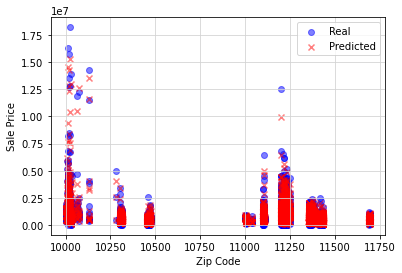

In [55]:
# Define x axis
x_axis = X_test.zipcode

# Build scatterplot
plt.scatter(x_axis, y_test, c = 'b', alpha = 0.5, marker = 'o', label = 'Real')
plt.scatter(x_axis, y1_pred, c = 'r', alpha = 0.5, marker = 'x', label = 'Predicted')
plt.xlabel('Zip Code')
plt.ylabel('Sale Price')
plt.grid(color = '#D3D3D3', linestyle = 'solid')
plt.legend(loc = 'upper right')
plt.show()

In [56]:
from sklearn.metrics import mean_squared_error, r2_score, mean_absolute_error

# Mean absolute error (MAE)
mae = mean_absolute_error(y_test.values.ravel(), y1_pred)

# Mean squared error (MSE)
mse = mean_squared_error(y_test.values.ravel(), y1_pred)

# Print metrics
print('Mean Absolute Error:', round(mae, 2))
print('Mean Squared Error:', round(mse, 2))

Mean Absolute Error: 80309.78
Mean Squared Error: 26566393440.16


### This cell should only be run to perform tuning of the algorithm. One tool used to do this is GridSearchCV method which will obtain the best parameters for the algorithm. Takes forever to run.

Import GridSearchCV
from sklearn.model_selection import GridSearchCV

Find the best parameters for the model
parameters = {
    'max_depth': [70, 80, 90, 100],
    'n_estimators': [900, 1000, 1100]
}
gridforest = GridSearchCV(model, parameters, cv = 3, n_jobs = -1, verbose = 1)
gridforest.fit(X_train, y_train)
gridforest.best_params_

In [57]:
# Get features list
characteristics = X1.columns

In [58]:
# Get the variables importances, sort them, and print the result
importances = list(model.feature_importances_)
characteristics_importances = [(characteristic, round(importance, 2)) for characteristic, importance in zip(characteristics, importances)]
characteristics_importances = sorted(characteristics_importances, key = lambda x: x[1], reverse = True)
[print('Variable: {:20} Importance: {}'.format(*pair)) for pair in characteristics_importances];

Variable: bath                 Importance: 0.34
Variable: zipcode              Importance: 0.25
Variable: days_on_market       Importance: 0.08
Variable: bed                  Importance: 0.06
Variable: type_is_completed_clean Importance: 0.06
Variable: health_level_dead    Importance: 0.02
Variable: ada_access_yes       Importance: 0.02
Variable: dom_iqr              Importance: 0.01
Variable: walkable_true        Importance: 0.01
Variable: health_level_fair    Importance: 0.01
Variable: health_level_good    Importance: 0.01
Variable: health_level_poor    Importance: 0.01
Variable: ada_access_partial   Importance: 0.01
Variable: type_is_active_cleanup_mild_threat Importance: 0.01
Variable: type_is_misdemeanor  Importance: 0.01
Variable: lunch_eligibity_high_false_elem Importance: 0.01
Variable: type_is_top_25th_percentile_elem Importance: 0.01
Variable: lunch_eligibity_high_false_middle Importance: 0.01
Variable: type_is_50th_percentile_middle Importance: 0.01
Variable: dom_tier       